## 1. Introduction
<p>Version control repositories like CVS, Subversion or Git can be a real gold mine for software developers. They contain every change to the source code including the date (the "when"), the responsible developer (the "who"), as well as little message that describes the intention (the "what") of a change.</p>
<p><a href="https://commons.wikimedia.org/wiki/File:Tux.svg">
<img style="float: right;margin:5px 20px 5px 1px" width="150px" src="https://s3.amazonaws.com/assets.datacamp.com/production/project_111/img/tux.png" alt="Tux - the Linux mascot">
</a></p>
<p>In this notebook, we will analyze the evolution of a very famous open-source project &ndash; the Linux kernel. The Linux kernel is the heart of some Linux distributions like Debian, Ubuntu or CentOS. </p>
<p>We get some first insights into the work of the development efforts by </p>
<ul>
<li>identifying the TOP 10 contributors and</li>
<li>visualizing the commits over the years.</li>
</ul>
<p>Linus Torvalds, the (spoiler alert!) main contributor to the Linux kernel (and also the creator of Git), created a <a href="https://github.com/torvalds/linux/">mirror of the Linux repository on GitHub</a>. It contains the complete history of kernel development for the last 13 years.</p>
<p>For our analysis, we will use a Git log file with the following content:</p>

In [178]:
# Printing the content of git_log_excerpt.csv
print(open('datasets/git_log_excerpt.csv'))

<_io.TextIOWrapper name='datasets/git_log_excerpt.csv' mode='r' encoding='UTF-8'>


## 2. Reading in the dataset
<p>The dataset was created by using the command <code>git log --encoding=latin-1 --pretty="%at#%aN"</code>. The <code>latin-1</code> encoded text output was saved in a header-less csv file. In this file, each row is a commit entry with the following information:</p>
<ul>
<li><code>timestamp</code>: the time of the commit as a UNIX timestamp in seconds since 1970-01-01 00:00:00 (Git log placeholder "<code>%at</code>")</li>
<li><code>author</code>: the name of the author that performed the commit (Git log placeholder "<code>%aN</code>")</li>
</ul>
<p>The columns are separated by the number sign <code>#</code>. The complete dataset is in the <code>datasets/</code> directory. It is a <code>gz</code>-compressed csv file named <code>git_log.gz</code>.</p>

In [180]:
# Loading in the pandas module
import pandas as pd

# Reading in the log file
git_log = pd.read_csv('datasets/git_log.gz', sep='#', 
                      encoding='latin-1', header=None, names=['timestamp', 'author'])

# Printing out the first 5 rows
print(git_log.head())

    timestamp          author
0  1502826583  Linus Torvalds
1  1501749089   Adrian Hunter
2  1501749088   Adrian Hunter
3  1501882480       Kees Cook
4  1497271395       Rob Clark


## 3. Getting an overview
<p>The dataset contains the information about every single code contribution (a "commit") to the Linux kernel over the last 13 years. We'll first take a look at the number of authors and their commits to the repository.</p>

In [182]:
# calculating number of commits
number_of_commits = len(git_log) + - 1

# calculating number of authors
git_log.dropna(inplace=True)
number_of_authors = len(git_log.author.unique())

# printing out the results
print("%s authors committed %s code changes." % (number_of_authors, number_of_commits))

17385 authors committed 699070 code changes.


## 4. Finding the TOP 10 contributors
<p>There are some very important people that changed the Linux kernel very often. To see if there are any bottlenecks, we take a look at the TOP 10 authors with the most commits.</p>

In [184]:
# Identifying the top 10 authors
top_10_authors = git_log.author.value_counts().dropna()[:10]

# Listing contents of 'top_10_authors'
top_10_authors

Linus Torvalds           23361
David S. Miller           9106
Mark Brown                6802
Takashi Iwai              6209
Al Viro                   6006
H Hartley Sweeten         5938
Ingo Molnar               5344
Mauro Carvalho Chehab     5204
Arnd Bergmann             4890
Greg Kroah-Hartman        4580
Name: author, dtype: int64

## 5. Wrangling the data
<p>For our analysis, we want to visualize the contributions over time. For this, we use the information in the <code>timestamp</code> column to create a time series-based column.</p>

In [186]:
# converting the timestamp column
git_log['timestamp'] = pd.to_datetime(git_log.timestamp, unit='s')

# summarizing the converted timestamp column
git_log.timestamp.describe()

count                  699070
unique                 668447
top       2008-09-04 05:30:19
freq                       99
first     1970-01-01 00:00:01
last      2037-04-25 08:08:26
Name: timestamp, dtype: object

## 6. Treating wrong timestamps
<p>As we can see from the results above, some contributors had their operating system's time incorrectly set when they committed to the repository. We'll clean up the <code>timestamp</code> column by dropping the rows with the incorrect timestamps.</p>

In [188]:
# determining the first real commit timestamp
git_log = git_log.sort_values(by='timestamp')
first_commit_timestamp = git_log[git_log['author'] == 'Linus Torvalds'][0:1]
first_commit_timestamp = pd.to_datetime(first_commit_timestamp['timestamp'].values[0])

# determining the last sensible commit timestamp
last_commit_timestamp = pd.to_datetime('today')

# filtering out wrong timestamps
corrected_log = git_log[(git_log['timestamp'] >= first_commit_timestamp) & 
                        (git_log['timestamp'] <= last_commit_timestamp)]

# summarizing the corrected timestamp column
corrected_log['timestamp'].describe()

count                  698568
unique                 667976
top       2008-09-04 05:30:19
freq                       99
first     2005-04-16 22:20:36
last      2017-10-03 12:57:00
Name: timestamp, dtype: object

## 7. Grouping commits per year
<p>To find out how the development activity has increased over time, we'll group the commits by year and count them up.</p>

In [190]:
# Counting the no. commits per year
commits_per_year = corrected_log.groupby(
    pd.Grouper(
        key='timestamp', 
        freq='AS'
        )
    )

# Listing the first rows
commits_per_year.head()

,timestamp,author
699070,2005-04-16 22:20:36,Linus Torvalds
699069,2005-04-16 22:23:53,Christoph Lameter
699068,2005-04-16 22:23:54,Neil Brown
699067,2005-04-16 22:23:55,akpm@osdl.org
699066,2005-04-16 22:23:56,akpm@osdl.org
683210,2006-01-01 01:00:29,Linus Torvalds
683209,2006-01-01 01:18:52,Stas Sergeev
683208,2006-01-01 13:23:47,Jan-Benedict Glaw
676512,2006-01-01 19:07:00,Steve Grubb
683188,2006-01-02 02:04:44,Benjamin Herrenschmidt


## 8. Visualizing the history of Linux
<p>Finally, we'll make a plot out of these counts to better see how the development effort on Linux has increased over the the last few years. </p>

timestamp
2005-01-01    Axes(0.125,0.125;0.775x0.775)
2006-01-01    Axes(0.125,0.125;0.775x0.775)
2007-01-01    Axes(0.125,0.125;0.775x0.775)
2008-01-01    Axes(0.125,0.125;0.775x0.775)
2009-01-01    Axes(0.125,0.125;0.775x0.775)
2010-01-01    Axes(0.125,0.125;0.775x0.775)
2011-01-01    Axes(0.125,0.125;0.775x0.775)
2012-01-01    Axes(0.125,0.125;0.775x0.775)
2013-01-01    Axes(0.125,0.125;0.775x0.775)
2014-01-01    Axes(0.125,0.125;0.775x0.775)
2015-01-01    Axes(0.125,0.125;0.775x0.775)
2016-01-01    Axes(0.125,0.125;0.775x0.775)
2017-01-01    Axes(0.125,0.125;0.775x0.775)
Freq: AS-JAN, dtype: object

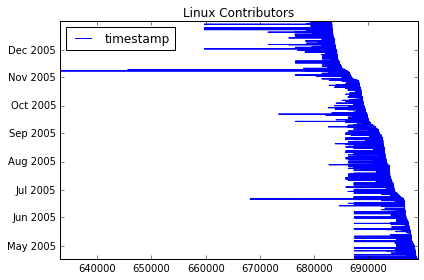

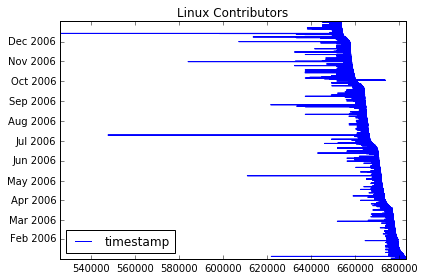

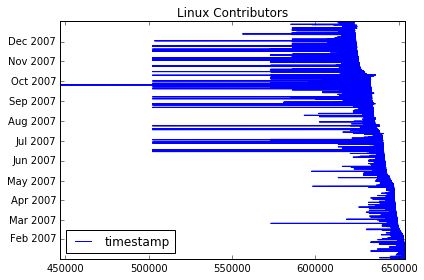

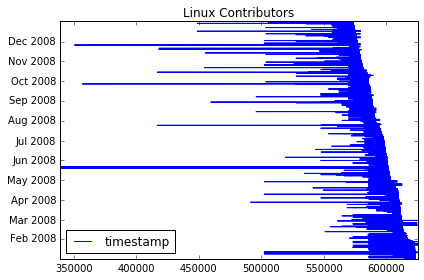

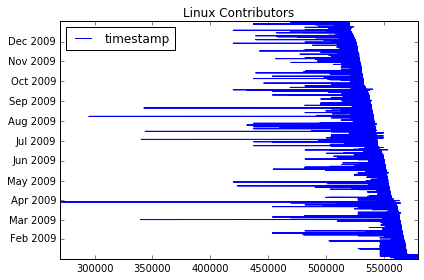

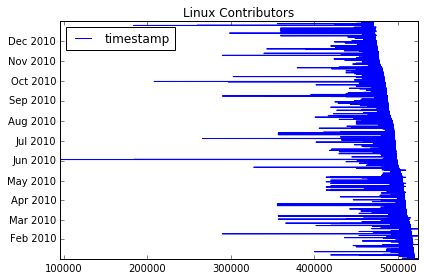

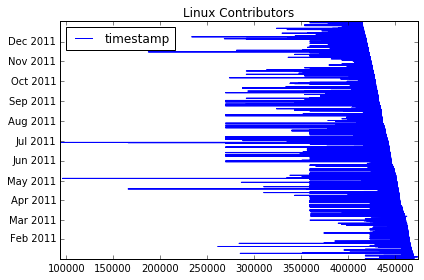

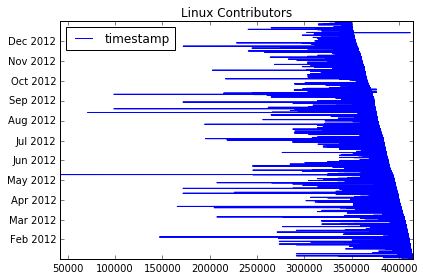

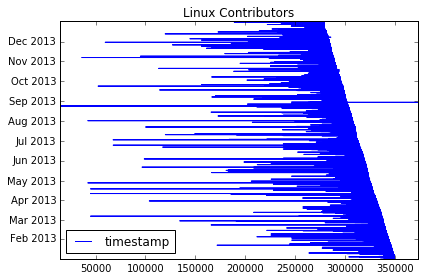

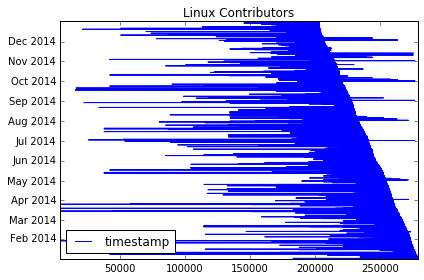

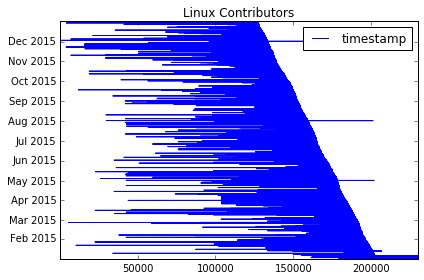

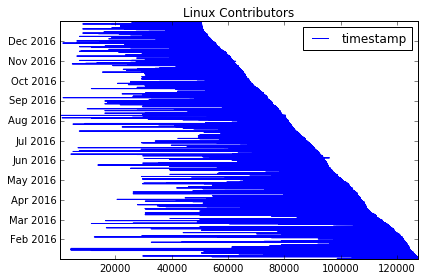

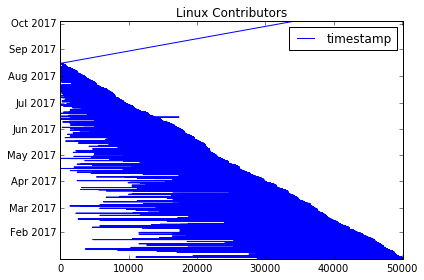

In [192]:
# Setting up plotting in Jupyter notebooks
%matplotlib inline

# plot the data
commits_per_year.plot(title='Linux Contributors')

## 9.  Conclusion
<p>Thanks to the solid foundation and caretaking of Linux Torvalds, many other developers are now able to contribute to the Linux kernel as well. There is no decrease of development activity at sight!</p>

In [194]:
# calculating or setting the year with the most commits to Linux
year_with_most_commits = 2016 